# Import the neccessary libraries

In [1]:
import spacy
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import multiprocessing
from gensim.models import Word2Vec
import seaborn as sns

# Import tensorflow module
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2

# Import sklearn module
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils.data_preprocessing as data_preprocessing
import utils.url_loader as url_loader

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Data Processing

## Run to remove duplicates
~~df = data_preprocessing.remove_duplicate(newDfName)~~

"if you omit the duplicates, that will skew the base rate of each distinct object. If the training data are a representative sample of the real world, then you don't want that, because you will actually be training for a slightly different world (one with different base rates)."

In [3]:
#Print the number of rows in the dataset
df = pd.read_csv('./data/balanced_urls.csv')

row_count = df.shape[0]
print(row_count)
display('DataFrame Shape {}'.format(df.shape))

# LSTM 
df_lstm = df.copy()

# K-Means Clustering
df_kmeans = df.copy()

632508


'DataFrame Shape (632508, 3)'

## Dataframe info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632508 entries, 0 to 632507
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     632508 non-null  object
 1   label   632508 non-null  object
 2   result  632508 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.5+ MB


## Check for NaN Values

In [5]:
df.isnull().sum()

url       0
label     0
result    0
dtype: int64

## Count unique data in 'label' column

In [6]:
df.label.value_counts()

label
benign       316254
malicious    316254
Name: count, dtype: int64

# K-Means Clustering Model Preparation

In [7]:
df_kmeans['url_length'] = df_kmeans['url'].apply(lambda x: len(str(x))) # Get Length of URL
df_kmeans['digits_in_url'] = df_kmeans['url'].apply(lambda x: url_loader.count_digits(x)) # Get Number of Digits in URL
df_kmeans['non_numerical_in_url'] = df_kmeans['url'].apply(lambda x: url_loader.count_nonDigitsAlpahbet(x)) # Get Number of Non-Numeric in URL
df_kmeans['domain_name'] = df_kmeans['url'].apply(lambda x: url_loader.get_domain_name(x)) # Get Domain Name of URL

df_kmeans.head()

,url,label,result,url_length,digits_in_url,non_numerical_in_url,domain_name
0,https://www.google.com,benign,0,22,0,5,www.google.com
1,https://www.youtube.com,benign,0,23,0,5,www.youtube.com
2,https://www.facebook.com,benign,0,24,0,5,www.facebook.com
3,https://www.baidu.com,benign,0,21,0,5,www.baidu.com
4,https://www.wikipedia.org,benign,0,25,0,5,www.wikipedia.org


In [8]:
X_kmeans = df_kmeans
y_kmeans = df_kmeans['result']

X_kmeans_train, X_kmeans_test, y_kmeans_train, y_kmeans_test=train_test_split(X_kmeans,y_kmeans, test_size=0.1, random_state=21)

In [9]:
X_kmeans_train_new = pd.DataFrame()
X_kmeans_train_new['url_length'] = X_kmeans_train['url_length']
X_kmeans_train_new['non_numerical_alphabetical_in_url'] = X_kmeans_train['non_numerical_in_url']
X_kmeans_train_new['digits_in_url'] = X_kmeans_train['digits_in_url']
X_kmeans_train_new['results'] = X_kmeans_train['result']

## Check for missing values
``

In [10]:
X_kmeans_train_new.isna().sum()
missing_cols, missing_rows = (
    (X_kmeans_train_new.isnull().sum(x) | X_kmeans_train_new.eq('').sum(x))
    .loc[lambda x: x.gt(0)].index
    for x in (0, 1)
)
X_kmeans_train_new.loc[missing_rows]

,url_length,non_numerical_alphabetical_in_url,digits_in_url,results


# K-Means Clustering Preparation

In [11]:
X_kmeans = X_kmeans_train_new
X_kmeans = X_kmeans.drop('results', axis=1)
X_kmeans = MinMaxScaler().fit_transform(X_kmeans)
display(X_kmeans)
y_kmeans = X_kmeans_train_new['results']

array([[0.0177259 , 0.04624277, 0.00271003],
       [0.0077821 , 0.03468208, 0.        ],
       [0.02377864, 0.05202312, 0.        ],
       ...,
       [0.04539559, 0.10404624, 0.01897019],
       [0.04712495, 0.13294798, 0.01084011],
       [0.01124081, 0.02312139, 0.00542005]])

In [12]:
kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans.fit(X_kmeans)
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 0])

In [13]:
correct_labels = sum(y_kmeans == kmeans.labels_)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y_kmeans.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y_kmeans.size)))

Result: 315770 out of 569257 samples were correctly labeled.
Accuracy score: 0.55


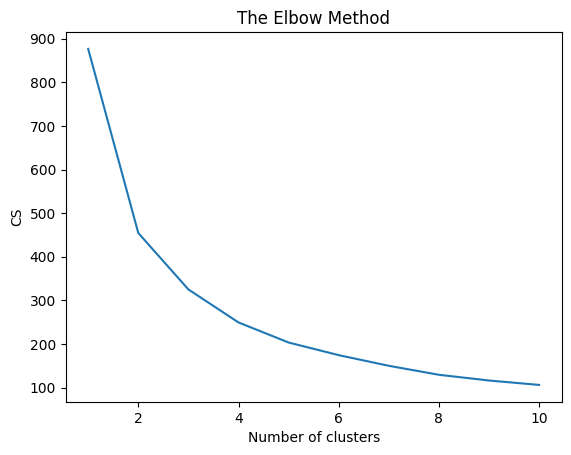

In [14]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_kmeans)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [15]:
X_kmeans_test = X_kmeans_test.drop('url', axis=1)
X_kmeans_test = X_kmeans_test.drop('label', axis=1)
X_kmeans_test = X_kmeans_test.drop('result', axis=1)
X_kmeans_test = X_kmeans_test.drop('domain_name', axis=1)
y_kmeans_predict = kmeans.predict(X_kmeans_test)

# print(y_kmeans_predict)

c:\Users\garet\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [16]:
correct_labels = sum(y_kmeans_test == y_kmeans_predict)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y_kmeans_test.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y_kmeans_test.size)))

Result: 0 out of 63251 samples were correctly labeled.
Accuracy score: 0.00


# LSTM Model Preparation

## Tokenizing the URL - Word2Vec                        

In [17]:
# Initialize list
txt = [url_loader.tokenize_url_regex(word) for word in df_lstm['url']]
print(txt[:5])
print(len(txt))

# Add tokenized url to new dataset to feed to word2vec model
df_lstm['tokenized_url'] = txt

[['www', 'google', 'com'], ['www', 'youtube', 'com'], ['www', 'facebook', 'com'], ['www', 'baidu', 'com'], ['www', 'wikipedia', 'org']]
632508


## Building Word2Vec Model

In [18]:
# Get number of cores
cores = multiprocessing.cpu_count()

# Initialize Word2Vec Model
word2vec_model = Word2Vec(
    min_count = 1,
    vector_size=32,
    window=5,
    workers=1
)

In [19]:
# Build the Word2Vec Vocabulary Corpus
word2vec_model.build_vocab(txt, progress_per=10000)

In [20]:
# Train the Word2Vec Model
word2vec_model.train(txt, total_examples=len(txt), epochs=10, report_delay=1)

(25884811, 35939220)

## Get Vocab Size, Input Length, and Embedding Size

In [21]:
# Get Vocab Size
vocab=word2vec_model.wv
vocab_size=len(vocab)
print(f"The number of vocab: {vocab_size}")

The number of vocab: 706209


In [22]:
# Get Keys from Word2Vec Model
vocab_keys=list(vocab.index_to_key)

In [23]:
# Create External Dictionary to store Key-Value Pairs
word_vec_dict={}
for words in vocab_keys:
    word_vec_dict[words]=vocab.get_vector(words)
print(f"Number of key-value pairs {len(word_vec_dict)}")
display(word_vec_dict)

Number of key-value pairs 706209


{'www': array([-0.16392612, -4.726726  , -1.8850063 ,  3.2154717 ,  2.3137572 ,
         2.7536817 ,  0.46457672, -1.6215109 , -2.714124  , -2.7330432 ,
         0.17448625, -1.3903059 ,  5.2241693 , -2.4256127 ,  0.33229184,
         0.41014597, -1.620965  ,  2.041005  , -1.4585975 , -4.187466  ,
         2.1475544 ,  6.229112  , -1.3579336 ,  1.7351207 ,  1.8791312 ,
         1.1519353 ,  3.3820164 ,  0.80877995,  0.12908538,  3.1579497 ,
         1.6275793 ,  3.1178715 ], dtype=float32),
 'com': array([-1.4931347e+00, -4.3978791e+00,  2.3499875e+00,  1.8029244e+00,
         1.9461242e+00,  4.8077097e+00,  4.7769159e-02, -3.0233779e+00,
        -3.5066173e+00, -1.6159244e+00,  6.4443791e-01, -2.9556413e+00,
         2.7827492e-01, -5.0248260e+00, -1.2683178e+00,  3.6493847e+00,
        -5.5061722e+00,  1.8201463e-03, -1.3781114e+00, -3.7983465e+00,
        -8.3408725e-01,  7.2262293e-01,  2.0873789e-01, -5.2338117e-01,
        -4.1137102e-01,  1.6982734e+00, -9.2034733e-01,  1.006466

In [24]:
# Get Maximum Length of Tokenized URL
maxi=-1
for i, rev in enumerate(df_lstm['tokenized_url']):
    if(len(rev)>maxi):
        maxi=len(rev)
print(maxi)

59


In [25]:
# Create a Index to Word Mapping for the Tokenized URLs
tok = Tokenizer()
tok.fit_on_texts(df_lstm['tokenized_url'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df_lstm['tokenized_url'])
display(encd_rev)

[[1, 59, 2],
 [1, 19, 2],
 [1, 21, 2],
 [1, 10738, 2],
 [1, 15, 5],
 [1, 18941, 2],
 [1, 38, 2],
 [1, 59, 10, 49],
 [1, 5420, 2],
 [1, 35, 2],
 [1, 24565, 2],
 [1, 179, 2],
 [1, 18942, 2],
 [1, 59, 10, 53],
 [1, 3396, 2],
 [1, 371, 2],
 [1, 8091, 2],
 [1, 24566, 2],
 [1, 29098, 2, 123],
 [1, 8844, 2],
 [1, 46288, 2],
 [1, 8456, 123],
 [1, 59, 11],
 [1, 59, 10, 13],
 [1, 59, 2, 17],
 [1, 59, 46],
 [1, 59, 26],
 [1, 798, 2],
 [1, 3702, 26],
 [1, 238, 18942, 2],
 [1, 47, 2],
 [1, 46289, 194],
 [1, 59, 27],
 [1, 249, 10],
 [1, 59, 2, 789],
 [1, 3772, 2],
 [1, 59, 67],
 [1, 125521, 2],
 [1, 3583, 2],
 [1, 38, 10, 53],
 [1, 59, 14],
 [1, 184, 2],
 [1, 59, 2, 195],
 [1, 328, 2],
 [1, 6359, 2],
 [1, 13070, 2],
 [1, 654, 26],
 [1, 66021, 2],
 [1, 58, 2],
 [1, 12213, 2],
 [1, 169, 2],
 [1, 66022, 2],
 [1, 187, 26],
 [1, 552, 2],
 [1, 125522, 8],
 [1, 790, 2],
 [1, 334, 2],
 [1, 112, 2],
 [1, 59, 2, 23],
 [1, 59, 2, 264],
 [1, 4555, 2],
 [1, 4468, 2],
 [1, 4319, 2],
 [1, 59, 2, 893],
 [1, 140, 2]

In [26]:
# Initialize Input Length and Embedding Size
max_url_len = maxi+1 #(60)
embed_dim=32

In [27]:
# Ensure all URL sequence has the same length which is the maximum length of the tokenized url
pad_rev=pad_sequences(encd_rev, maxlen=max_url_len, padding="post")
pad_rev.shape
display(pad_rev[0])
print(type(pad_rev))

array([ 1, 59,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

<class 'numpy.ndarray'>


In [28]:
# Creating a Word Embedding Matrix to be passed onto the Embedding Layer of the Deep Learning model
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word, i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:
        embed_matrix[i]=embed_vector
print(embed_matrix[3])

[-4.23986769  0.4207153  -1.82774532  4.88833618  0.86612016  3.35527158
 -0.76370633  0.19181286 -2.49896646 -2.70550299 -2.17346883 -2.70412087
  4.90047169 -0.57700872 -1.16083765  1.01923347 -3.26551795 -0.17041942
  1.66766655 -3.13256741  2.99551868  3.78392315  0.51098096  0.29228783
 -1.8520658   3.64446712  0.04784838  0.66185039 -1.69866872  5.83817911
  2.18656278  4.07662296]


# LSTM Model Building and Training

In [29]:
# Initialize the y axis
y_lstm = df_lstm['result']

# Splitting the dataset into train and test dataset
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test=train_test_split(pad_rev,y_lstm, test_size=0.1, random_state=21)

display(pad_rev)

array([[  1,  59,   2, ...,   0,   0,   0],
       [  1,  19,   2, ...,   0,   0,   0],
       [  1,  21,   2, ...,   0,   0,   0],
       ...,
       [  1, 969,   2, ...,   0,   0,   0],
       [  9,  15,   5, ...,   0,   0,   0],
       [  1, 155,   2, ...,   0,   0,   0]])

In [30]:
# Initialize the LSTM MODEL

from tensorflow.keras.initializers import Constant
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_url_len, embeddings_initializer=Constant(embed_matrix)))
# lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_url_len))
# lstm_model.add(Flatten())
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(1, activation='relu')) 
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the lstm_model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            22027552  
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 22,052,449
Trainable params: 22,052,449
Non-trainable params: 0
_________________________________________________________________


In [31]:
history=lstm_model.fit(X_lstm_train, y_lstm_train, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
7116/7116 [==============================] - 176s 24ms/step - loss: 0.4512 - accuracy: 0.7361 - val_loss: 0.1799 - val_accuracy: 0.9448
Epoch 2/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.1600 - accuracy: 0.9512 - val_loss: 0.1256 - val_accuracy: 0.9643
Epoch 3/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.0857 - accuracy: 0.9822 - val_loss: 0.1227 - val_accuracy: 0.9661
Epoch 4/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.0591 - accuracy: 0.9896 - val_loss: 0.1853 - val_accuracy: 0.9333
Epoch 5/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.0520 - accuracy: 0.9921 - val_loss: 0.1223 - val_accuracy: 0.9639
Epoch 6/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.0424 - accuracy: 0.9936 - val_loss: 0.1443 - val_accuracy: 0.9579
Epoch 7/25
7116/7116 [==============================] - 172s 24ms/step - loss: 0.0393 - accuracy: 0.9945 - val_loss: 0

lstm_model.save('./LSTM_Model_V2/lstmv2_model.h5')
lstm_model.save_weights('./LSTM_Model_V2/lstmv2_modelWeights')
lstm_model.save_weights('./LSTM_Model_V2/lstmv2_modelWeights.h5')`

In [40]:
lstm_model.save('./docker/LSTM_Model_V2_pytf/lstmv3_model.h5')

## Evaluate Model

1977/1977 [==============================] - 10s 5ms/step
[[0.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


<Axes: >

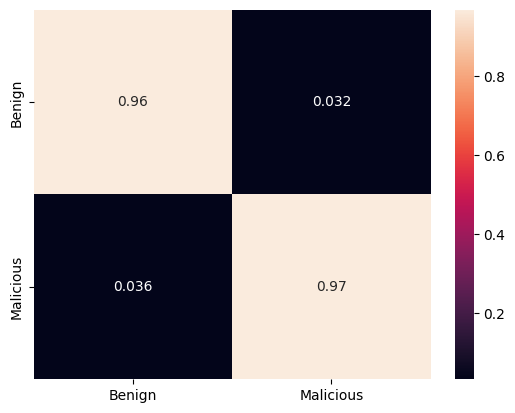

In [32]:
# Predict the values
y_lstm_predict = lstm_model.predict(X_lstm_test).round()
print(y_lstm_predict)

# Create a confusion matrix based on a predicted column
result = confusion_matrix(y_lstm_test, y_lstm_predict, normalize='pred')

# Plot Confusion Matrix
sns.heatmap(result, annot=True, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
# sns.heatmap()

In [33]:

scores = lstm_model.evaluate(X_lstm_test, y_lstm_test)

1977/1977 [==============================] - 12s 6ms/step - loss: 0.1383 - accuracy: 0.9658


In [34]:
print(history.params)
print(history.history.keys())

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

{'verbose': 1, 'epochs': 25, 'steps': 7116}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and Validation Loss')

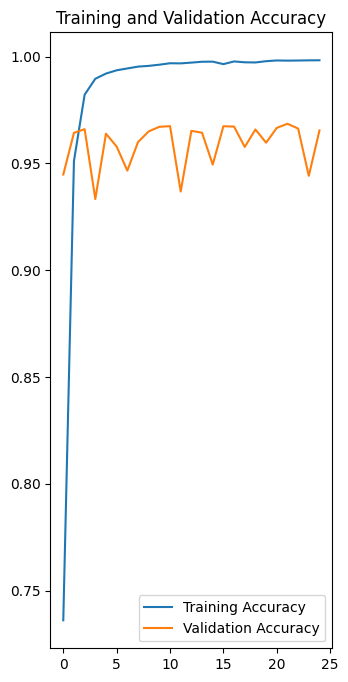

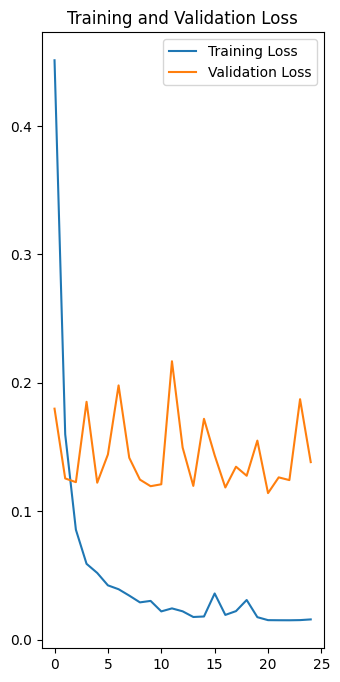

In [35]:
EPOCHS = 25
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [51]:
def newe(url):
    txt = [url_loader.tokenize_url_regex(word) for word in df['url']]
    df['tokenized_url'] = txt
    max_url_len = 60
    tok = Tokenizer()
    tok.fit_on_texts(df['tokenized_url'])
    tokenized_url = url_loader.tokenize_url_regex(url)
    encd_rev = tok.texts_to_sequences(tokenized_url)
    encd_revs = [[item for sublist in encd_rev for item in sublist]]
    pad_rev=pad_sequences(encd_revs, maxlen=max_url_len, padding="post")
    return pad_rev

display(X_lstm_test.shape)
val = newe('https://codedamn.com/news/javascript/javascript-round-a-number-to-2-decimal-places-with-examples')
display(val.shape)

a = lstm_model.predict(val)
print(a[0][0])
# ones, nones = 0, 0

new = tf.keras.models.load_model('LSTM_Model_V2_pytf/lstmv2_model.h5')
display(new.predict(val))
# for _ in range(50):
#         predicted = new.predict(val).round()
#         if predicted == 1:
#             ones += 1
#         else:
#             nones += 1
        
#     if ones > nones:
#         return "Malicious", ((ones/50)*100)
#     else:
#         return "Benign", ((nones/50)*100)

# results = confusion_matrix(y_lstm_test, new_pred, normalize='pred')

# # Plot Confusion Matrix
# sns.heatmap(results, annot=True, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])

(63251, 60)

(1, 60)

1/1 [==============================] - 0s 158ms/step
0.9999722
1/1 [==============================] - 0s 453ms/step


array([[0.99999976]], dtype=float32)